<a href="https://colab.research.google.com/github/carmencheong/Email-spam-detection/blob/master/practical_spam_email_classification_using_bert_ipynb_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/.config/config_sentinel
/content/.config/.last_update_check.json
/content/.config/active_config
/content/.config/gce
/content/.config/.last_survey_prompt.yaml
/content/.config/.last_opt_in_prompt.yaml
/content/.config/default_configs.db
/content/.config/configurations/config_default
/content/.config/logs/2023.10.26/13.24.09.918386.log
/content/.config/logs/2023.10.26/13.24.27.273292.log
/content/.config/logs/2023.10.26/13.24.01.273477.log
/content/.config/logs/2023.10.26/13.23.35.885303.log
/content/.config/logs/2023.10.26/13.24.17.396802.log
/content/.config/logs/2023.10.26/13.24.26.535618.log
/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_test.csv


## Importing required packages

In [10]:
!pip install tensorflow_text #Resolve ModuleNotFoundError: No module named 'tensorflow_text'
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 20.2 MB/s eta 0:00:00


## Reading the dataset
### Author: CJM

In [15]:
# df=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding = "ISO-8859-1")
df=pd.read_csv('/content/subset_emails.csv', encoding = "ISO-8859-1")
df.head(5)

,text,spam
0,Subject: grab this quick triple at its low ho...,1
1,"Subject: yyyy , do you know the hgh difference...",1
2,Subject: make big money with foreclosed real e...,1
3,Subject: are you ready to get it ? hello ! v...,1
4,Subject: letter from : daniel kabila letter f...,1


## Drop the unnecessary columns-'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'
### Author: CJM

In [16]:
df.columns

Index(['text', 'spam'], dtype='object')

In [17]:
# df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df = df.iloc[:, :2]
df.rename(columns = {'text':'Content', 'spam':'Category'}, inplace = True)
# df['Category'] = df['Category'].apply(lambda x: 'ham' if x == 0 else 'spam')
# df['Category'] = df['Category'].replace({0: 'ham', 1: 'spam'})
# df['Category'] = df['Category'].replace({'0': 'ham', '1': 'spam'})
df['Category'] = df['Category'].replace([1], 'spam')
df['Category'] = df['Category'].replace([0], 'ham')
df.tail(5)

,Content,Category
5670,Subject: re : research and development charges...,ham
5671,"Subject: re : receipts from visit jim , than...",ham
5672,Subject: re : enron case study update wow ! a...,ham
5673,"Subject: re : interest david , please , call...",ham
5674,Subject: news : aurora 5 . 2 update aurora ve...,ham


In [18]:
df.head(5)

,Content,Category
0,Subject: grab this quick triple at its low ho...,spam
1,"Subject: yyyy , do you know the hgh difference...",spam
2,Subject: make big money with foreclosed real e...,spam
3,Subject: are you ready to get it ? hello ! v...,spam
4,Subject: letter from : daniel kabila letter f...,spam


## Understanding the dataset

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5675 entries, 0 to 5674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Content   5675 non-null   object
 1   Category  5675 non-null   object
dtypes: object(2)
memory usage: 88.8+ KB


In [20]:
df.shape

(5675, 2)

In [21]:
df.groupby('Category').describe()

Content                                                            \
           count unique                                                top   
Category                                                                     
ham         4358   4325  Subject: re : eprm 2001 houston  layla ,  my a...   
spam        1317   1317  Subject: grab this quick triple at its low  ho...   

               
         freq  
Category       
ham         2  
spam        1

In [22]:
print('% Imbalanced Data:',1317/4358) # spam count/ham count

% Imbalanced Data: 0.30220284534189995


## Handling Imbalanced Data

In [23]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(1317, 2)

In [24]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4358, 2)

In [25]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(1317, 2)

In [26]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(2634, 2)

In [27]:
df_balanced['Category'].value_counts()

ham     1317
spam    1317
Name: Category, dtype: int64

In [28]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Content,Category,spam
1407,Subject: re : american express charges hi sam...,ham,0
3044,"Subject: re : charm jim , i shall be glad to...",ham,0
938,Subject: for your information this is going t...,spam,1
3648,Subject: thank you ! fyi from valeria . - - ...,ham,0
1272,Subject: pleasure your women - size does matte...,spam,1


#### Now the dataset is balanced.

## Making a new 'spam' column
If Category is ham:spam=0

else:spam=1

In [29]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Content,Category,spam
0,Subject: grab this quick triple at its low ho...,spam,1
1,"Subject: yyyy , do you know the hgh difference...",spam,1
2,Subject: make big money with foreclosed real e...,spam,1
3,Subject: are you ready to get it ? hello ! v...,spam,1
4,Subject: letter from : daniel kabila letter f...,spam,1


## Splitting the dataset into training and testing

**Use stratify so that in train and test data distribution of category is equal**

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Content'],df_balanced['spam'], stratify=df_balanced['spam'])

In [31]:
X_train.head()

1493    Subject: re : alp presentation  vince ,  thank...
2135    Subject: files in houston  hi ,  i am trying t...
2503    Subject: re : london contact number  hi anita ...
407     Subject: undelivered mail returned to sender  ...
877     Subject: your in - home source of health infor...
Name: Content, dtype: object

## About the BERT trained model

BERT stands for Bidirectional Encoder Representations from Transformers. BERT is a model which is quite bidirectional. Bidirectional means BERT learns information from both the left and right sides of a token’s context. A model’s bidirectionality is essential for completely understanding the meaning of a language.

BERT has been pre-trained on a vast corpus of unlabeled text, including the entire Wikipedia, which is 2,500 million words long, and various Book Corpus, which is over 800 million words long. Half of BERT’s success can be attributed to this pre-training phase.

**Working of BERT**

To learn the contextual relationships between words in a text, BERT utilizes Transformer, an attention mechanism. The transformer’s vanilla implementation has two mechanisms: an encoder that receives text input and a decoder that predicts the task. Only the encoder mechanism is required because the purpose of BERT is to construct a language model.

The Transformer encoder reads the entire sequence of words at once, unlike directional versions that read the text input sequentially. It is classed as bidirectional as a result of this, while the actual term is non-directional. This feature allows the model to learn a word’s context based on its surroundings.

(visit https://analyticsindiamag.com/a-guide-to-text-preprocessing-using-bert/)

### Download the BERT pretrained model

bert_preprocess=converts raw text to the numeric input tensors expected by the encoder.

bert_encoder=uses the encoder stack of the transformer model to output the representation of each token in the given input.

In [32]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
# bert_preprocess = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
# bert_encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2")

In [33]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

### Get embedding vectors for few sentence and compare them using cosine similarity

In [34]:
c=get_sentence_embeding(['mango','banana','Narendra modi','data analytics','natural language processing'])

### Value near to 1 depict they are similar and 0 depict they are different

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([c[0]],[c[1]])

array([[0.99540985]], dtype=float32)

In [36]:
cosine_similarity([c[3]],[c[4]])

array([[0.96571267]], dtype=float32)

In [37]:
cosine_similarity([c[1]],[c[2]])

array([[0.9482186]], dtype=float32)

## Model Building

Here we will build functional model.

* Functional model offers more flexibility over sequential model because we don’t need to attach layers in sequential order.
* In Functional model, part or all of the inputs directly connected to the output layer.
* This architecture makes it possible for the neural network to learn both deep patterns and simple rules.

In [38]:
#Functional Model

# Bert layers
#Text input passed to bert_preprocess
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
#Processed text passed to bert_encoder
outputs = bert_encoder(preprocessed_text)

# Neural network layers

#Dropout
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [40]:
len(X_train)

1975

In [41]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

## Training Model

In [42]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
62/62 [==============================] - 35s 325ms/step - loss: 0.6721 - accuracy: 0.5939 - precision: 0.6006 - recall: 0.5617
Epoch 2/10
62/62 [==============================] - 20s 322ms/step - loss: 0.5866 - accuracy: 0.7256 - precision: 0.7347 - recall: 0.7065
Epoch 3/10
62/62 [==============================] - 21s 341ms/step - loss: 0.5410 - accuracy: 0.7595 - precision: 0.7594 - recall: 0.7601
Epoch 4/10
62/62 [==============================] - 21s 332ms/step - loss: 0.4982 - accuracy: 0.7995 - precision: 0.7942 - recall: 0.8087
Epoch 5/10
62/62 [==============================] - 21s 335ms/step - loss: 0.4782 - accuracy: 0.8030 - precision: 0.8156 - recall: 0.7834
Epoch 6/10
62/62 [==============================] - 21s 341ms/step - loss: 0.4493 - accuracy: 0.8147 - precision: 0.8226 - recall: 0.8026
Epoch 7/10
62/62 [==============================] - 21s 339ms/step - loss: 0.4273 - accuracy: 0.8263 - precision: 0.8171 - recall: 0.8411
Epoch 8/10
62/62 [================

In [43]:
model.evaluate(X_test, y_test)

21/21 [==============================] - 8s 334ms/step - loss: 0.3709 - accuracy: 0.8725 - precision: 0.9070 - recall: 0.8298


[0.37088221311569214,
 0.8725341558456421,
 0.9069767594337463,
 0.8297872543334961]

#### We can believe on accuracy as we have balanced the dataset.

## Testing the model

In [44]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

21/21 [==============================] - 8s 338ms/step


In [45]:
#If probablity greater than 0.5 than make it 1 otherwise 0.
#If y_predicted=1->spam
#else:Not spam
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm

array([[302,  28],
       [ 56, 273]])

### Heatmap

Text(50.722222222222214, 0.5, 'Truth')

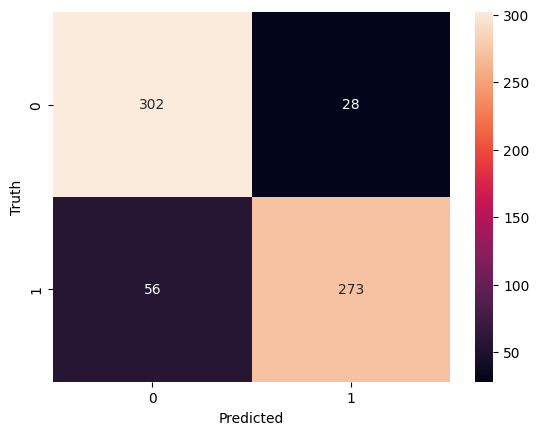

In [47]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Classification Report

In [48]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       330
           1       0.91      0.83      0.87       329

    accuracy                           0.87       659
   macro avg       0.88      0.87      0.87       659
weighted avg       0.88      0.87      0.87       659



In [51]:
import csv

# Initialize an empty list to store the lines
lines = []

# Specify the path to your CSV file
csv_file = '/content/spams.csv'

# Open the CSV file and read it line by line
with open(csv_file, 'r', encoding='utf-8') as file:  # Specify the encoding if necessary
    for line in file:
        lines.append(line.strip())  # Use strip() to remove leading/trailing whitespace

# Now, the 'lines' list contains each line of the CSV as a string
print(lines)
print("Author: CJM")

['\ufeff"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : 

## Testing on Random Input
### Author: CJM

In [52]:
# reviews = [
#     'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
#     'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
#     'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
#     'Hey Sam, Are you coming for a cricket game tomorrow',
#     "Why don't you wait 'til at least wednesday to see if you get your ."]


reviews = lines
model.predict(reviews)

2/2 [==============================] - 1s 382ms/step


array([[0.9113143 ],
       [0.8090593 ],
       [0.6699844 ],
       [0.35684797],
       [0.93183327],
       [0.8775916 ],
       [0.6396583 ],
       [0.82138675],
       [0.5130433 ],
       [0.8637308 ],
       [0.63467485],
       [0.86817735],
       [0.7888087 ],
       [0.6447679 ],
       [0.73823386],
       [0.85127085],
       [0.9249877 ],
       [0.69305205],
       [0.6464788 ],
       [0.67404073],
       [0.9681266 ],
       [0.506391  ],
       [0.8102772 ],
       [0.9178935 ],
       [0.8372936 ],
       [0.880158  ],
       [0.883756  ],
       [0.8317578 ],
       [0.81298375],
       [0.8417377 ],
       [0.79333115],
       [0.6549593 ],
       [0.66336346],
       [0.77869093],
       [0.7385281 ],
       [0.58775973],
       [0.8144213 ],
       [0.8997707 ],
       [0.87878   ],
       [0.59666616],
       [0.69815993],
       [0.8278352 ],
       [0.77915144],
       [0.957518  ],
       [0.88429445],
       [0.54883736],
       [0.9496806 ],
       [0.596

#### Thus in above example we conclude that the first three mails are spam while other two are not spam.

In [53]:
len(lines)

51

In [55]:
import numpy as np

# Count the values lower than 0.5
model_output = np.array([[0.9113143 ],
       [0.8090593 ],
       [0.6699844 ],
       [0.35684797],
       [0.93183327],
       [0.8775916 ],
       [0.6396583 ],
       [0.82138675],
       [0.5130433 ],
       [0.8637308 ],
       [0.63467485],
       [0.86817735],
       [0.7888087 ],
       [0.6447679 ],
       [0.73823386],
       [0.85127085],
       [0.9249877 ],
       [0.69305205],
       [0.6464788 ],
       [0.67404073],
       [0.9681266 ],
       [0.506391  ],
       [0.8102772 ],
       [0.9178935 ],
       [0.8372936 ],
       [0.880158  ],
       [0.883756  ],
       [0.8317578 ],
       [0.81298375],
       [0.8417377 ],
       [0.79333115],
       [0.6549593 ],
       [0.66336346],
       [0.77869093],
       [0.7385281 ],
       [0.58775973],
       [0.8144213 ],
       [0.8997707 ],
       [0.87878   ],
       [0.59666616],
       [0.69815993],
       [0.8278352 ],
       [0.77915144],
       [0.957518  ],
       [0.88429445],
       [0.54883736],
       [0.9496806 ],
       [0.5968412 ],
       [0.6244414 ],
       [0.32384065],
       [0.34338605]])
count_lower_than_0_5 = np.sum(model_output < 0.5)

# Count the values equal to or greater than 0.5
count_greater_than_or_equal_to_0_5 = np.sum(model_output >= 0.5)

print("Count of values lower than 0.5:", count_lower_than_0_5)
print("Count of values equal to or greater than 0.5:", count_greater_than_or_equal_to_0_5)

Count of values lower than 0.5: 3
Count of values equal to or greater than 0.5: 48


In [56]:
48/51

0.9411764705882353